In [1]:
import os
from pathlib import Path, PurePath
import math
from fastai.vision.all import *
from nnAudio import features
import torchaudio
from torchvision import transforms as T

In [6]:
path = Path('../dataset/DeepShip')
sr = 32000

In [7]:
fns =  get_files(path,'.wav')

In [8]:
# How much skip for a full minute  minute

In [10]:
# Figure out fft sizes
# STFT LF
imgsize = 460
Fmax = sr / 2
Nfft_lf = 32768

Fbin_lf = Fmax / Nfft_lf
Nskip_lf = 4103 # int(round((sr * 60 - Nfft_lf) / imgsize)) # makes a minute 
rng_lf = Nskip_lf * imgsize + Nfft_lf
stft_lf = features.STFT(n_fft=Nskip_lf, hop_length=Nskip_lf, freq_bins=None, 
              window='hann', freq_scale='linear', center=True, pad_mode='constant',
              output_format='Magnitude', sr=sr,verbose=False).to('cuda:0')
# STFT HF
Nfft_hf = 4096
Fbin_hf = Fmax / Nfft_hf
Nskip_hf = 2078 #int(round((sr * 60 - Nfft_hf*2) / imgsize)/2 ) # half a minute
rng_hf = Nskip_hf * imgsize + Nfft_hf
stft_hf = features.STFT(n_fft=Nfft_hf, hop_length=Nskip_hf, freq_bins=None, 
              window='hann', freq_scale='linear', center=True, pad_mode='constant',
              output_format='Magnitude', sr=sr, verbose=False).to('cuda:0')


rng_cqt = round(rng_lf / 3)
bpo= 80
cqt_ = features.CQT(sr=sr,bins_per_octave=bpo, hop_length=1392, fmin=1, n_bins=imgsize, verbose=False).to('cuda:0')

RuntimeError: CUDA out of memory. Tried to allocate 7.19 GiB (GPU 0; 9.78 GiB total capacity; 128.30 MiB already allocated; 5.23 GiB free; 138.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
Nskip_lf

In [ ]:
FmaxCqt = 250 * pow(2,imgsize/bpo);FmaxCqt 

In [ ]:
#features.CQT?

In [ ]:
def normSamp(audio):
    ret = audio - torch.mean(audio)
    return ret / torch.max(ret)

def normSpec(spec):
    # take the logarithm of the values
    ret = torch.log10(spec)
    mean = torch.mean(ret)
    std = torch.std(ret)
    # Normalize each frame so its max 1, we dont need the extra dimension
    #return (ret / torch.transpose(torch.max(ret,2)[0],0,1))[0]
    #return (ret / torch.max(ret))[0]
    ret =  (ret - mean) / (std*4) + 0.5
    return torch.clamp(ret, min=0, max=1) 

def normCqt(cqt):
    ret = torch.log10(cqt) / 2
    #return (ret / torch.max(ret,1)[0])[0]
    ret = (ret - torch.mean(ret) + 0.5)
    return torch.clamp(ret, min=0, max=1) 

In [50]:
def readWav(p: Path, rand=True):
    frames = torchaudio.info(p).num_frames
    last = frames-rng_lf
    wav = torch.Tensor()  
    # Repeat wav if not long enough
    while last < 0:
        wav = torch.cat((wav,torchaudio.load(p)[0]),1)
        last += frames
    # Random start point
    start = random.randint(0,last) if rand else int(last/2)
    if frames-rng_lf > 0: 
        return torchaudio.load(p, num_frames=rng_lf, frame_offset=start)[0]
    else: 
        wav = torch.cat((wav,torchaudio.load(p)[0]),1)
        #print(p)
        #print(wav.shape)
        #print(rng_lf)
        return wav[:,start:start+rng_lf]


In [51]:
samps = readWav(fns[89])

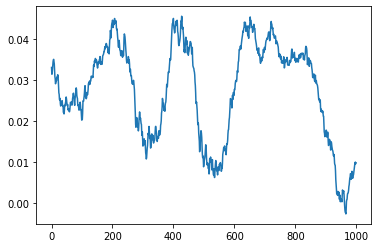

In [52]:
plt.plot(range(1000),samps[0,0:1000])

In [53]:
def wavToSpecs(wavs : torch.Tensor):
    lf = normSpec(stft_lf(wavs)[0,1:imgsize+1, 0:imgsize])
    hf = normSpec(stft_hf(wavs)[0,55:imgsize+55, :])
    hf0 = hf[:,:imgsize]
    hf1 = hf[:,imgsize:imgsize*2]

    cqt = normCqt(cqt_(wavs)[0])
    cqt0 = cqt[:,:imgsize]
    cqt1 = cqt[:,imgsize:imgsize*2]
    cqt2 = cqt[:,imgsize*2:imgsize*3]
    
    return torch.stack((lf,hf0,hf1,cqt0,cqt1,cqt2),0)

In [54]:
Fbin_lf

0.48828125

In [55]:
wavs = readWav(fns[22]).to('cuda:0')
specs = wavToSpecs(wavs)

In [56]:
wavs.shape

torch.Size([1, 1920148])

In [57]:
specs.shape

torch.Size([6, 460, 460])

In [58]:
rng_lf

1920148

In [59]:
rng_hf*2

1919952

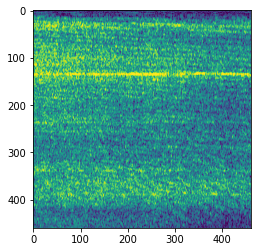

In [60]:
plt.imshow(specs[0,:,:].cpu())


In [61]:
(Fbin_lf*imgsize, 'hf from:', Fbin_hf*55, 'to:',Fbin_hf*(imgsize+55), FmaxCqt)

(224.609375, 'hf from:', 214.84375, 'to:', 2011.71875, 13454.342644059432)

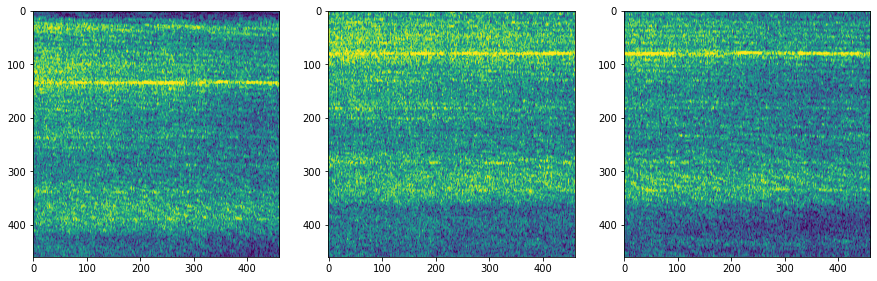

In [62]:
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(specs[0,:,:].cpu())
axarr[1].imshow(specs[1,:,:].cpu())
axarr[2].imshow(specs[2,:,:].cpu())




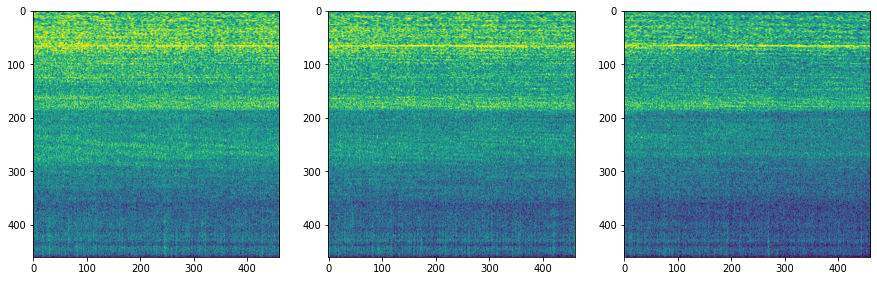

In [63]:
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(specs[3,:,:].cpu())
axarr[1].imshow(specs[4,:,:].cpu())
axarr[2].imshow(specs[5,:,:].cpu())

In [24]:
# open 3 consecutive channels of a tensor as an image
def show_tensor(tensor, first_channel = 0):
    if tensor.is_cuda: 
        plt.imshow((tensor[first_channel:3+first_channel].cpu()).permute(1, 2, 0).numpy())
        return   
    plt.imshow(tensor[first_channel:3+first_channel].permute(1, 2, 0).numpy())

def wavs(p : Path):
    return get_files(p,'.wav')

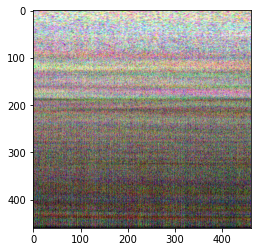

In [25]:
show_tensor(specs,first_channel=3)

In [26]:
#norm = T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [27]:
def label_func(p : Path):
    if PurePath(p).parent.name == "AmbientSE": return []
    return [PurePath(p).parent.parent.name]

In [28]:
class TitledImage(fastuple):
    def show(self, figsize=None, ctx=None, **kwargs): 
        img, label = self
        print(img.shape)
        if not isinstance(img, Tensor): return ctx
        if figsize is None: figsize=(10,10)
        return show_image(img[0,0], title=label, ctx=ctx, **kwargs)


In [29]:
#show_image??

In [30]:
# Make a fastai Transform
class SpectrogramTransform(RandTransform):
    "A transform handler for multiple `spect` transforms"
    split_idx,order=None,0  # 0 = HIGH prio
    #def __init__(self, train_aug, valid_aug): store_attr()
    def __init__(self): 
        store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, p : Path):
        
        if self.idx == 0: #Train transform
            wav = readWav(p, True)
        else: #Valid transform
            wav = readWav(p, False)
        return wavToSpecs(wav.cuda())
    
    #def decodes(self, x): return TitledImage(x,'test')

class ImgTransform(ItemTransform):
    def __init__(self, vocab): self.vocab = vocab
    def encodes(self, o): return o
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [31]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [32]:
norm = Normalize.from_stats([0.485, 0.456, 0.406,0.485, 0.456, 0.406],[0.229, 0.224, 0.225,0.229, 0.224, 0.225])
db = DataBlock(blocks=(TransformBlock(type_tfms=SpectrogramTransform),  MultiCategoryBlock),
               get_items = wavs,
               get_y = label_func,
               splitter = RandomSplitter(valid_pct=0.2, seed=42),
               #item_tfms=ImgTransform(),
               batch_tfms= norm  
             )

In [33]:
#db.summary(path)

In [34]:
#def SpectrogramBlock(cls=Spectrogram) : 
#    "A `TransformBlock` for spectograms of `cls`"
#    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [35]:
dls = db.dataloaders(path, bs=16, num_workers=0)

In [36]:
dls.vocab

['Cargo', 'Passengership', 'Tanker', 'Tug']

In [37]:
#show_at(dls, 0)

In [38]:
dls.one_batch()[0].shape

torch.Size([16, 6, 460, 460])

In [39]:
learn = cnn_learner(dls, resnet50,  n_in=6, pretrained=True,
                    loss_func=BCEWithLogitsLossFlat(), 
                    metrics=[accuracy_multi]).to_fp16() #partial(accuracy_multi, thresh=0.95)

In [56]:
# grab a reference to the first layer of the model, the layer we need to edit to pull over the pretrained weights
layer1 = learn.model[0][0]
print(layer1)
# access the weights of the layer
l1_weights = layer1.weight
print(l1_weights.shape)

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([64, 6, 7, 7])


In [57]:
learn.model[0][0].weight[0:3,5,0:3,0:3]

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [58]:
l1_weights.shape

torch.Size([64, 6, 7, 7])

In [59]:
channel_count = 6
pretrained_channel_count = 3
channel_ratio = channel_count/pretrained_channel_count

# define how many times we need to duplicate the weights
repeat_count = math.ceil(channel_ratio)

# duplicate the RGB weights for all additional channels
#           RGB weights       repeat on 2nd axis     chops off any excess
l1_weights = l1_weights[:,:pretrained_channel_count].repeat(1,repeat_count,1,1)[:,:channel_count]

# rescale weights by channel_ratio
l1_weights = l1_weights / channel_ratio

# set the weights
learn.model[0][0].weight[:,:,:,:] = l1_weights

SuggestedLRs(valley=0.002511886414140463)

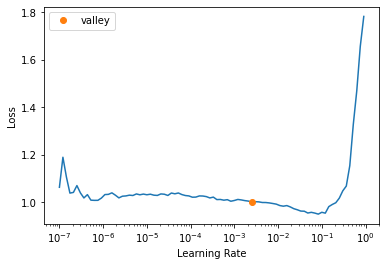

In [60]:
learn.lr_find()

In [45]:
SaveModelCallback?

Init signature:
SaveModelCallback(
    monitor='valid_loss',
    comp=None,
    min_delta=0.0,
    fname='model',
    every_epoch=False,
    at_end=False,
    with_opt=False,
    reset_on_fit=True,
)
Docstring:      A `TrackerCallback` that saves the model's best during training and loads it at the end.
File:           ~/miniconda/lib/python3.9/site-packages/fastai/callback/tracker.py
Type:           type
Subclasses:     


In [ ]:
cbs = [SaveModelCallback(fname='accuracy_multi',monitor='accuracy_multi')]
learn.fine_tune(1000,base_lr=2.5e-3, cbs=cbs)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.222463,0.427657,0.832661,00:16


Better model found at epoch 0 with accuracy_multi value: 0.8326612710952759.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.252175,0.424373,0.834677,00:16
1,0.232852,0.415046,0.842742,00:16
2,0.229449,0.397036,0.838710,00:16
3,0.213253,0.378556,0.852823,00:16
4,0.212534,0.436427,0.816532,00:16
5,0.203240,0.383031,0.838710,00:16
6,0.196346,0.367960,0.848790,00:16
7,0.194365,0.364988,0.854839,00:16
8,0.201872,0.395228,0.844758,00:16
9,0.187573,0.366148,0.844758,00:16


Better model found at epoch 0 with accuracy_multi value: 0.8346773982048035.
Better model found at epoch 1 with accuracy_multi value: 0.8427419066429138.
Better model found at epoch 12 with accuracy_multi value: 0.8608871102333069.
Better model found at epoch 17 with accuracy_multi value: 0.8649193644523621.
Better model found at epoch 19 with accuracy_multi value: 0.8850806355476379.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [47]:
#learn.load('accuracy_multi')

In [48]:
#interp = ClassificationInterpretation.from_learner(learn,)
#interp.plot_confusion_matrix()

In [49]:
#for i in range(dls.valid.n):
#    print(dls.valid.dataset[i][1])

In [50]:
def predTensor(p: Path):
    frames = torchaudio.info(p).num_frames
    last = frames-rng_lf
    wav,_ = torchaudio.load(p)
    # Repeat wav if not long enough
    while last < 0:
        wav = torch.cat((wav,torchaudio.load(p)[0]),1)
        last += frames
    spec = wavToSpecs(wav[0:rng_lf*2].cuda())[None,:,:,:]
    
    # cat rest of the frames
    runs = int((frames-Nfft_lf)/Nskip_lf/imgsize)
    print(runs, frames, Nskip_lf,rng_lf)
    start = Nskip_lf * (imgsize)
    for i in range(1,runs):
        idx = start*i
        if idx+rng_lf > frames: 
            spec = torch.cat((spec,wavToSpecs(wav[:,-rng_lf:].cuda())[None,:,:,:]),0)
            break
        spec = torch.cat((spec,wavToSpecs(wav[:,idx:idx+rng_lf].cuda())[None,:,:,:]),0)
    return spec
    

In [51]:
spec = predTensor(Path('./hurtigbaat test mono.wav'))
spec.shape

2 4891989 4103 1920148


torch.Size([2, 6, 460, 460])

In [52]:
# Patch learner for batch predictions
def predict_batch(self, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl(item, rm_type_tfms=rm_type_tfms, num_workers=0)
    ret, _,mask = self.get_preds(dl=dl, with_decoded=True)
    return ret, mask
Learner.predict_batch = predict_batch

In [53]:
preds = learn.predict_batch(spec)

In [54]:
show_tensor(spec[3])

IndexError: index 3 is out of bounds for dimension 0 with size 2

In [ ]:
torch.mean(preds[0],0)

In [ ]:
preds[1]

In [ ]:
preds[1]*preds[0]

In [ ]:
wsum = preds[1]*preds[0]
p = torch.mean(wsum,0).tolist()

In [ ]:
result =  tuple(zip(dls.vocab, p))

In [ ]:
result

In [ ]:
learn.predict(spec[0])

dls